## 1. IMPORTS

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

## 2. SYNTHETIC SOLAR RADIANCE DATASET

In [78]:
class SyntheticSolarRadianceDataset(Dataset):

    def __init__(
        self,
        n_samples=200,
        low_res=32,        # 🔴 32 × 32 → 22 km grid
        high_res=704,      # 🔴 704 × 704 → 1 km grid
        n_vars=1,          # 🔴 solar radiance = scalar
        seed=42
    ):
        super().__init__()
        self.low_res = low_res
        self.high_res = high_res
        self.n_vars = n_vars

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.samples = [self._generate_sample() for _ in range(n_samples)]

    # -----------------------------------------------------
    # High-resolution solar radiance field (1 km)
    # -----------------------------------------------------
    def _generate_high_res_field(self):
        field = torch.zeros(self.n_vars, self.high_res, self.high_res)

        x = torch.linspace(0, 2 * np.pi, self.high_res)
        y = torch.linspace(0, 2 * np.pi, self.high_res)
        X, Y = torch.meshgrid(x, y, indexing="ij")

        #Solar-radiance-like spatial patterns
        cloud_core = 0.6 * torch.exp(-((X - np.pi)**2 + (Y - np.pi)**2) / 6.0)
        mesoscale = 0.3 * torch.sin(3 * X) * torch.sin(3 * Y)
        fine_edges = 0.1 * torch.sin(12 * X) * torch.cos(12 * Y)
        noise = 0.03 * torch.randn_like(X)

        field[0] = cloud_core + mesoscale + fine_edges + noise

        # Normalize radiance to [0, 1]
        field = (field - field.min()) / (field.max() - field.min())

        return field

    # -----------------------------------------------------
    # Generate one (input, target) pair
    # -----------------------------------------------------
    def _generate_sample(self):
        # High-resolution truth (1 km)
        high_res = self._generate_high_res_field()

        # 🔴 Physical downsampling (22 km satellite footprint)
        low_res = F.adaptive_avg_pool2d(
            high_res.unsqueeze(0),
            (self.low_res, self.low_res)
        ).squeeze(0)

        # 🔴 Upsample BEFORE FNO (grid alignment only)
        low_res_up = F.interpolate(
            low_res.unsqueeze(0),
            size=(self.high_res, self.high_res),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        # Coordinate embedding (critical)
        x = torch.linspace(0, 1, self.high_res)
        y = torch.linspace(0, 1, self.high_res)
        X, Y = torch.meshgrid(x, y, indexing="ij")
        coords = torch.stack([X, Y], dim=0)

        # 🔴 Input = [radiance + x + y]
        inp = torch.cat([low_res_up, coords], dim=0)

        return inp, high_res

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

        # -----------------------------------------------------
    # DEBUG: Print and inspect one sample
    # -----------------------------------------------------
    def debug_print_sample(self, idx=0):
        inp, target = self.samples[idx]

        print("========== DEBUG SAMPLE ==========")
        print(f"Sample index: {idx}")

        print("\n--- INPUT ---")
        print(f"Input shape        : {inp.shape}")
        print(f"Input dtype        : {inp.dtype}")
        print(f"Input min / max    : {inp.min().item():.4f} / {inp.max().item():.4f}")

        print("\nInput channels:")
        print(f"  Channel 0 (radiance) min/max : "
              f"{inp[0].min().item():.4f} / {inp[0].max().item():.4f}")
        print(f"  Channel 1 (x-coord)  min/max : "
              f"{inp[1].min().item():.4f} / {inp[1].max().item():.4f}")
        print(f"  Channel 2 (y-coord)  min/max : "
              f"{inp[2].min().item():.4f} / {inp[2].max().item():.4f}")

        print("\n--- TARGET (GROUND TRUTH) ---")
        print(f"Target shape       : {target.shape}")
        print(f"Target dtype       : {target.dtype}")
        print(f"Target min / max   : {target.min().item():.4f} / {target.max().item():.4f}")

        print("==================================")


In [79]:
dataset = SyntheticSolarRadianceDataset(n_samples=10)
dataset.debug_print_sample(idx=0)


========== DEBUG SAMPLE ==========
Sample index: 0

--- INPUT ---
Input shape        : torch.Size([3, 704, 704])
Input dtype        : torch.float32
Input min / max    : 0.0000 / 1.0000

Input channels:
  Channel 0 (radiance) min/max : 0.1075 / 0.8977
  Channel 1 (x-coord)  min/max : 0.0000 / 1.0000
  Channel 2 (y-coord)  min/max : 0.0000 / 1.0000

--- TARGET (GROUND TRUTH) ---
Target shape       : torch.Size([1, 704, 704])
Target dtype       : torch.float32
Target min / max   : 0.0000 / 1.0000


## 3. SPECTRAL CONVOLUTION (CANONICAL FNO)

In [80]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, padding=8):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.padding = padding

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.randn(
                in_channels,
                out_channels,
                modes1,
                modes2,
                dtype=torch.cfloat
            )
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Physical padding (non-periodic fix)
        x = F.pad(x, [0, self.padding, 0, self.padding], mode="reflect")
        Hp, Wp = x.shape[-2], x.shape[-1]

        # FFT
        x_ft = torch.fft.rfft2(x, norm="ortho")

        # Spectral multiplication
        out_ft = torch.zeros(
            B, self.out_channels, Hp, Wp // 2 + 1,
            device=x.device, dtype=torch.cfloat
        )

        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, :self.modes1, :self.modes2],
            self.weights
        )

        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, -self.modes1:, :self.modes2],
            self.weights
        )

        # Inverse FFT
        x = torch.fft.irfft2(out_ft, s=(Hp, Wp), norm="ortho")

        # Crop back
        return x[..., :H, :W]

## 4. FNO MODEL

In [81]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_channels, out_channels, n_layers=4):
        super().__init__()

        self.fc0 = nn.Linear(in_channels, width)

        self.spectral_layers = nn.ModuleList([
            SpectralConv2d(width, width, modes1, modes2)
            for _ in range(n_layers)
        ])

        self.pointwise_layers = nn.ModuleList([
            nn.Conv2d(width, width, 1)
            for _ in range(n_layers)
        ])

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        # Lift
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        # FNO blocks
        for spec, pw in zip(self.spectral_layers, self.pointwise_layers):
            x = F.gelu(spec(x) + pw(x))

        # Project
        x = x.permute(0, 2, 3, 1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        x = x.permute(0, 3, 1, 2)

        return x


## 5. TRAINING UTILITIES

In [82]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)



## 6. MAIN (TRAIN + INFERENCE)

Epoch 01 | Train Loss 0.011098


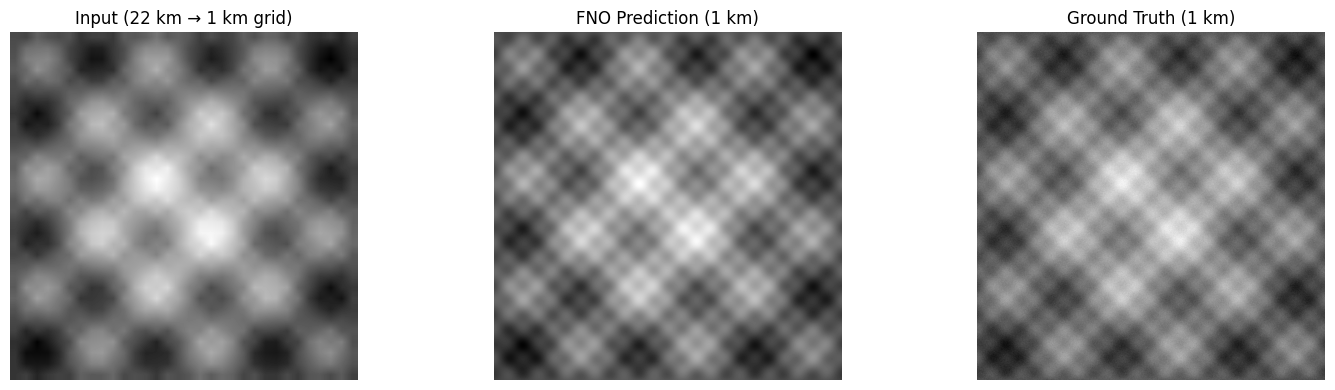

In [83]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = SyntheticSolarRadianceDataset(n_samples=100)
    train_loader = DataLoader(
        train_ds,
        batch_size=1,          # 🔴 REQUIRED: huge 704×704 fields
        shuffle=True
    )

    model = FNO2d(
        modes1=24,             # 🔴 higher modes for sharp radiance
        modes2=24,
        width=96,              # 🔴 more capacity
        in_channels=1 + 2,     # radiance + (x, y)
        out_channels=1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(1):
        loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        print(f"Epoch {epoch+1:02d} | Train Loss {loss:.6f}")

    # Inference demo
    x, y = train_ds[0]
    with torch.no_grad():
        pred = model(x.unsqueeze(0).to(device)).squeeze(0).cpu()

    # Visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].imshow(x[0], cmap="gray")
    axs[0].set_title("Input (22 km → 1 km grid)")
    axs[1].imshow(pred[0], cmap="gray")
    axs[1].set_title("FNO Prediction (1 km)")
    axs[2].imshow(y[0], cmap="gray")
    axs[2].set_title("Ground Truth (1 km)")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
